In [18]:
#%reset
"""
Definition of test problems
--------------------------------------------------------------------------
Created November 4 2023 for TRIPs-Py library
"""
__authors__ = "Mirjeta Pasha and Connor Sanderford"
__copyright__ = "Copyright 2022, TRIPs-Py library"
__license__ = "GPL"
__version__ = "0.1"
__maintainer__ = "Mirjeta Pasha and Connor Sanderford"
__email__ = "mirjeta.pasha@tufts.edu; mirjeta.pasha1@gmail.com and csanderf@asu.edu; connorsanderford@gmail.com"
import matplotlib
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power
from numpy import array, diag, dot, maximum, empty, repeat, ones, sum
from numpy.linalg import inv
import time
import scipy as sp
import scipy.stats as sps
import scipy.io as spio
import numpy as np
import astra
from trips.utilities.phantoms import *
from venv import create
import pylops
from scipy.ndimage import convolve
from scipy import sparse
import scipy.special as spe
from trips.utilities.testProblems import *
from trips.solvers.GKS import *
from trips.solvers.MMGKS import *
from trips.solvers.Tikhonov import *
from trips.solvers.tSVD import *
from trips.utilities.helpers import *
from trips.solvers.CGLS import TP_cgls
from trips.solvers.golub_kahan_tikhonov import *
from trips.solvers.GMRES import GMRES

#### In this notebook we illustrate how to use the Tomography class. The main features are:
1. Define e tomography problem where the forward operator can be formed explicitly as a matrix
 - 1.1 We show how to use SVD, compute the singular values of the operator, and illustrate the truncated SVD solution
 - 1.2 We use regularization methods for computing an approximate solution
2. Define a tomography problem where the forward operator is defined as a function and test solving the problem
3. Define a tomography problem by loading some saved data


#### 1. Define e tomography problem where the forward operator can be formed explicitly as a matrix

###### We define an operator, choose a phantom of any given size and plot the true phantom and the sinograpm as follows:

In [21]:
# Define an object of the class Tomogrpahy
Tomo = Tomography()
# Specify the dimensions of the phantom and the number of angels 
angels = 90
nx = 32
ny = 32
# Step 1: Define the operator as a matrix
Amat = Tomo.forward_Op_mat(nx, ny, angels)
# Step 2: Define the true solution. 
# Options are: grains, smooth, tectonic, threephases, ppower
testproblem = 'tectonic'
(x_true, nx, ny) = Tomo.gen_true(nx, ny, testproblem)
# Generate the data: We can skip Step 1 and generate the sinogram and the operator by the following lines
(A, b_true, p, q, AforMatrixOperation) = Tomo.gen_data(x_true, True, nx, ny, angels)
# Add noise in the true simulated sinogram b_true
# The opt defines the type of the noise. Options are Gaussian, Laplace, and Poisson
# The noise level defines the percentage of the noise added in the data. A value 0.1 means 10% additive noise
(b, delta) = Tomo.add_noise(b_true = b_true, opt = 'Gaussian', noise_level = 0.001)

In [16]:

S

array([52.99257893, 34.49777901, 34.48205889, ...,  0.31957471,
        0.15456328,  0.14920489])

array([52.99257893, 34.49777901, 34.48205889, ...,  0.31957471,
        0.15456328,  0.14920489])

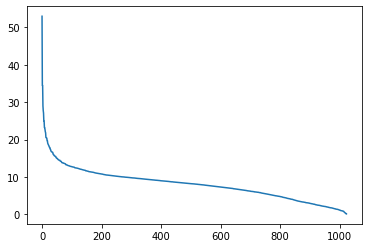

In [15]:
A.shape
A
[U, S, V] = la.svd(A.todense())
plt.plot(S)
S

generating basis...: 100%|██████████| 10/10 [00:00<00:00, 236.46it/s]

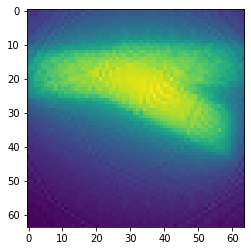

In [3]:
# Compute a solution Golub-Kahan
b_vec = b.reshape((-1,1))
projection_dim = 10
(U, B, V) = golub_kahan(A, b_vec, projection_dim)
VV = V
UU = U[:, 0:-1]
HH = B[0:-1, :]
bhat = UU.T.dot(b_vec)
y_tikh = np.linalg.solve(HH.T*HH, bhat)
x_GKahan = VV.dot(y_tikh)
plt.imshow(x_GKahan.reshape((nx,ny)))

In [25]:
# If the operator is sparse, we convert it to dense A.todense()
plot_singular_values_svd(Operator = A , parameter = 'A')
# If the operator is in the matrix form, but very large and sparse, the following commands can be used to compute the SVD
# import scipy
# [U, S, V] = scipy.sparse.linalg.svds(A, 100)
# 100 defines the number of singular values to be computed

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

###### Display the true image, the sinogram without noise and the noisy sinogram

(<AxesSubplot:title={'center':'b'}>,
 Text(0.5, 1.0, 'b'),
 (0.0, 1.0, 0.0, 1.0),
 <matplotlib.image.AxesImage at 0x7fdbb8ebce50>)

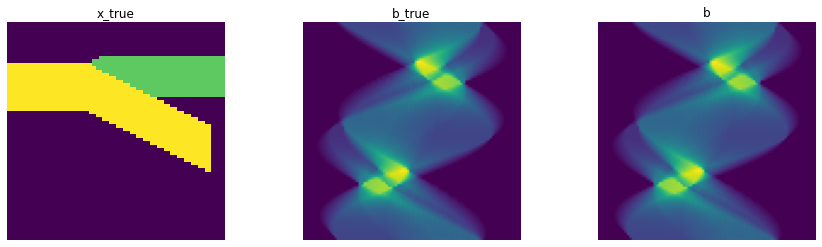

In [26]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1), plt.title('x_true'), plt.axis('off'), plt.imshow(x_true.reshape((nx,ny)))
plt.subplot(1,3,2), plt.title('b_true'), plt.axis('off'), plt.imshow(b_true.reshape((p,q)))
plt.subplot(1,3,3), plt.title('b'), plt.axis('off'), plt.imshow(b.reshape((p,q)))

##### 1.1. Compute the SVD of the operartor $A$ and plot the singlar values and the singular vectors
###### If the parameter is 'A' then we give the full operator to the function plot_singular_values_svd. The SVD is then computed and the singlar values are plotted. If the parameter is 'S' then we have precomputed the SVD from which we have S and the function plot_singular_values_svd will only plot the singular values. The same applies for plotting the singular vectors. If the operaror is not given, we give the matrix V.

In [27]:
# If the operator is sparse, we convert it to dense A.todense()
plot_singular_values_svd(Operator = A , parameter = 'A')
# If the operator is in the matrix form, but very large and sparse, the following commands can be used to compute the SVD
# import scipy
# [U, S, V] = scipy.sparse.linalg.svds(A, 100)
# 100 defines the number of singular values to be computed

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

In [28]:
plot_singular_vectors_svd(Operator = A.todense(), size = nx, parameter = 'A')

AttributeError: 'matrix' object has no attribute 'todense'

##### 1.1. Compute the truncated SVD solution of a problem by specifying how many singular values you want to keep after truncation

In [29]:
truncated_value = 15
b_vec = b.reshape((-1,1))
x_tsvd = TruncatedSVD_sol(A.todense(), truncated_value, b_vec)
plt.imshow(x_tsvd.reshape((nx, ny)))
plt.axis('off')

#### 1.2 Compute an approximate solution by using Generalized Krylov Subspace method (GKS)

In [120]:
# First we compute a naive solution
x_naive = A.T@b.reshape((-1,1))

In [9]:
# Define a derivative operator as a regularization operator
L = spatial_derivative_operator(nx, ny, 1)
data_vec = b.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_gks, info) = GKS(A, data_vec, L, projection_dim=3, n_iter = 60, regparam = 'dp', x_true = x_true.reshape(-1,1), delta = delta)

running GKS...: 100%|██████████| 60/60 [00:06<00:00,  8.77it/s]


In [10]:
info['Residual']

[3105.1229909865106,
 1570.472598568491,
 857.0860814140847,
 566.3795842440869,
 367.3845660120719,
 225.4364192749442,
 191.78377646985308,
 156.55425078412645,
 119.43666228910037,
 93.4061529746259,
 77.88233167357814,
 62.73885330094415,
 47.374791753797744,
 41.844970057870135,
 34.219835482711375,
 30.020056641299938,
 26.465302444198457,
 25.081967477566288,
 20.05400839781263,
 18.154828378870047,
 16.418430785811427,
 15.908220594751166,
 13.364572643747556,
 13.932202067914654,
 13.08021499477119,
 12.469100586060366,
 11.503658042281018,
 10.238118071355764,
 9.223252263210055,
 8.835541263535697,
 7.588635414728934,
 6.947945547839476,
 6.553997360489097,
 5.930807385531435,
 5.633153096098761,
 5.905774630663579,
 5.3478963518198945,
 5.157263855300576,
 5.026259902682356,
 3.7840055281524774,
 4.4878733698875095,
 4.138859197614336,
 4.2145722928701845,
 3.825341109029843,
 3.8948146514853033,
 3.4747377990469133,
 3.0965300094415817,
 2.698014856034857,
 2.5044612986273

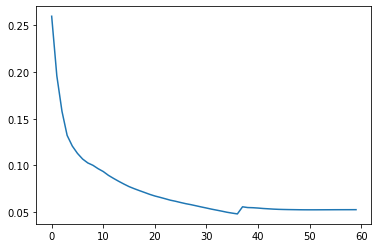

In [11]:
plt.plot(info['relError'])

In [12]:
info['relError']

[0.25983694976031385,
 0.19596309626012215,
 0.1578902612085567,
 0.13207549209272282,
 0.12068344097877319,
 0.11280809593710149,
 0.1067474838242561,
 0.10258762113209717,
 0.10003511626829904,
 0.09640421217469648,
 0.09335208552828186,
 0.08928492573926608,
 0.0859755822603131,
 0.08287210991420009,
 0.07993958760062947,
 0.07719737272607563,
 0.07496992128382901,
 0.07290804742366841,
 0.07091942910298785,
 0.06888721932983542,
 0.06713045003289882,
 0.06569807413335672,
 0.06419039000514268,
 0.06264299929903952,
 0.06148227962667595,
 0.060141122200464504,
 0.05888053176782008,
 0.05782941408907611,
 0.05661933111616975,
 0.05539072306048036,
 0.05423185361124627,
 0.05301963985958521,
 0.05193892983457782,
 0.05084751938716003,
 0.04968509626368012,
 0.04876711936463159,
 0.04791450001523251,
 0.055539692478872894,
 0.054742410362283916,
 0.054563818761739435,
 0.05420205460546732,
 0.053729114307881846,
 0.05339136927759139,
 0.05304616373604367,
 0.05281034704446335,
 0.05265

NameError: name 'x_naive' is not defined

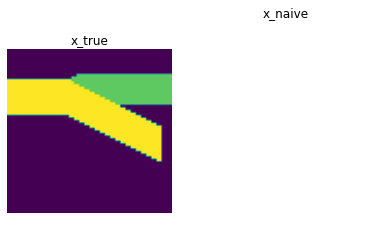

In [13]:
# Display the true desired vs the naive computed solution and vs the approximate regularized computed solution 
plt.figure(figsize=(10,4))
plt.subplot(1,3,1), plt.title('x_true'), plt.axis('off'), plt.imshow(x_true.reshape((nx,ny)))
plt.subplot(1,3,2), plt.title('x_naive'), plt.axis('off'), plt.imshow(x_naive.reshape((nx,ny)))
plt.subplot(1,3,3), plt.title('x_gks'), plt.axis('off'), plt.imshow(x_gks.reshape((nx, ny)))

2. Define a tomography problem where the forward operator is defined as a function and test solving the problem

In [20]:
# Define an object of the class Tomogrpahy
Tomo1 = Tomography()
# Specify the dimensions of the phantom and the number of angels 
views = 90
nx = 32
ny = 32
# Step 1: Define the true solution. 
# Options are: grains, smooth, tectonic, threephases, ppower
testproblem = 'ppower'
(x_true, nx, ny) = Tomo1.gen_true(nx, ny, testproblem)
# Step 2: Define the operator as a matrix
A = Tomo1.forward_Op(x_true, nx, ny, views)
# Generate the data: We can skip Step 1 and generate the sinogram and the operator by the following lines
(A, b_true, p, q, AforMatrixOperation) = Tomo1.gen_data(x_true, False, nx, ny, views)
# Add noise in the true simulated sinogram b_true
# The opt defines the type of the noise. Options are Gaussian, Laplace, and Poisson
# The noise level defines the percentage of the noise added in the data. A value 0.1 means 10% additive noise
(b, delta) = Tomo1.add_noise(b_true = b_true, opt = 'Gaussian', noise_level = 0.001)
b_vec = b.reshape((-1,1))

In [11]:
A.shape
A
[U, S, V] = la.svd(A.todense())

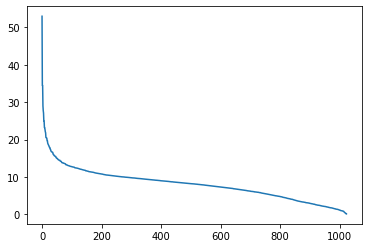

In [12]:
plt.plot(S)

In [17]:
from trips.utilities.operators import *

In [23]:
# Compute a solution by GKS
# Define a derivative operator as a regularization operator
L = spatial_derivative_operator(nx, ny, 1)
data_vec = b.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_mmgks, info_mmgks) = MMGKS(A, data_vec, L, pnorm=2, qnorm=1, projection_dim=2, n_iter =15, regparam = 'dp', x_true = x_true.reshape((-1,1)), delta = delta)

running MMGKS...: 100%|██████████| 15/15 [00:01<00:00,  7.76it/s]


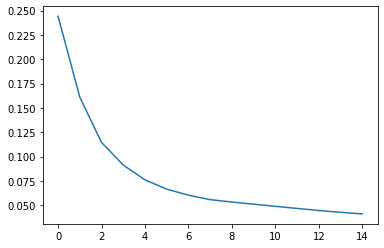

In [24]:
plt.plot(info_mmgks['relError'])

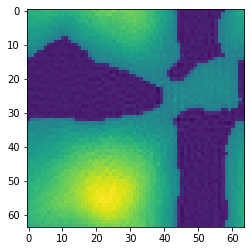

In [25]:
plt.imshow(x_mmgks.reshape((nx,ny)))

###### Display the true image, the sinogram without noise and the noisy sinogram

(<AxesSubplot:title={'center':'b'}>,
 Text(0.5, 1.0, 'b'),
 (0.0, 1.0, 0.0, 1.0),
 <matplotlib.image.AxesImage at 0x7fd2fac08b20>)

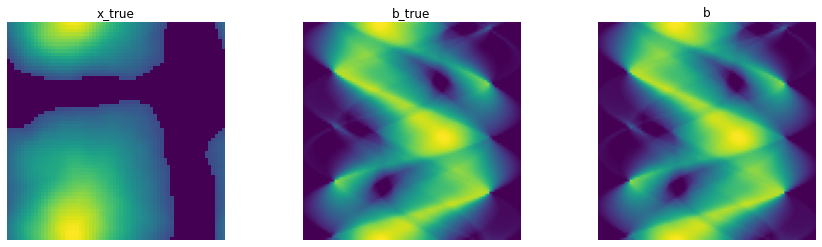

In [14]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1), plt.title('x_true'), plt.axis('off'), plt.imshow(x_true.reshape((nx,ny)))
plt.subplot(1,3,2), plt.title('b_true'), plt.axis('off'), plt.imshow(b_true.reshape((p,q)))
plt.subplot(1,3,3), plt.title('b'), plt.axis('off'), plt.imshow(b.reshape((p,q)))

##### Illustrate the ill-posedness of some inverse problem examples and show the need for regularization
<p>In this example we illustrate the following:

<p> Step 1: Compute a solution Golub-Kahan
<p> Step 2: Compute a solution Golub-Kahan-Tikhonov
<p> Step 2: Compute a solution by GKS


generating basis...: 100%|██████████| 10/10 [00:00<00:00, 327.41it/s]

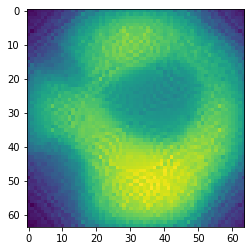

In [4]:
# Compute a solution Golub-Kahan
projection_dim = 10
(U, B, V) = golub_kahan(A, b_vec, projection_dim)
VV = V
UU = U[:, 0:-1]
HH = B[0:-1, :]
bhat = UU.T.dot(b_vec)
y_tikh = np.linalg.solve(HH.T*HH, bhat)
x_GKahan = VV.dot(y_tikh)
plt.imshow(x_GKahan.reshape((nx,ny)))

In [59]:
# Compute a solution Golub-Kahan-Tikhonov
(xgolub_kahan_tikhonov, reg_param) = golub_kahan_tikhonov(A, b.reshape((-1,1)), n_iter = 10, regparam = 'gcv', delta = delta)

generating basis...: 100%|██████████| 3/3 [00:00<00:00, 24.70it/s]


In [123]:
# Compute a solution by GKS
# Define a derivative operator as a regularization operator
L = spatial_derivative_operator(nx, ny, 1)
data_vec = b.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_gks, info) = GKS(A, data_vec, L, projection_dim=3, n_iter = 10, regparam = 0.001, x_true = x_true.reshape(-1,1))

running GKS...: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


ValueError: cannot reshape array of size 65536 into shape (64,64)

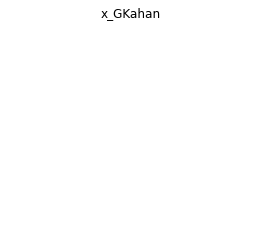

In [124]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1), plt.title('x_GKahan'), plt.axis('off'), plt.imshow(x_GKahan.reshape((nx,ny)))
plt.subplot(1,3,2), plt.title('x_golub_kahan_tikhonov'), plt.axis('off'), plt.imshow(xgolub_kahan_tikhonov.reshape((nx, ny)))
plt.subplot(1,3,3), plt.title('x_gks'), plt.axis('off'), plt.imshow(x_gks.reshape((nx,ny)))

### 3. Define a tomography problem by loading some saved data

In [27]:
# Define an object of the class Tomogrpahy
Tomo2 = Tomography()
# Specify the dimensions of the phantom and the number of angels 
# Step 1: Define the true solution. 
# Options are: grains, smooth, tectonic, threephases, ppower
testproblem = 'head'
(x_true, nx, ny) = Tomo1.gen_true(nx, ny, testproblem)
# Step 2: Define the operator as a matrix
A = Tomo1.forward_Op(x_true, nx, ny, views)
# Generate the data: We can skip Step 1 and generate the sinogram and the operator by the following lines
(A, x_true, b) = Tomo1.gen_saved_data('head')
b_vec = b.reshape((-1,1))

In [28]:
# Compute a solution by GKS
# Define a derivative operator as a regularization operator
L = spatial_derivative_operator(nx, ny, 1)
data_vec = b.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_gks, info) = GKS(A, data_vec, L, projection_dim=3, n_iter = 10, regparam = 1, x_true = x_true.reshape(-1,1))

running GKS...:  20%|██        | 2/10 [00:24<01:36, 12.03s/it]


KeyboardInterrupt: 

(Text(0.5, 1.0, 'x_gks'), (-0.5, 511.5, 511.5, -0.5))

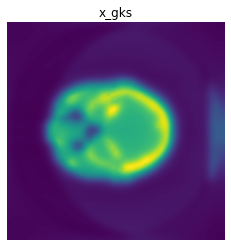

In [70]:
# Display the solution 
plt.imshow(x_gks.reshape((nx,ny)))
plt.title('x_gks'), plt.axis('off')

In [29]:
L = spatial_derivative_operator(nx, ny, 1)
data_vec = b.reshape((-1,1))

In [30]:
def MMGKS11(A, b, L, pnorm=2, qnorm=1, projection_dim=3, n_iter=5, regparam='gcv', x_true=None, **kwargs):

    dp_stop = kwargs['dp_stop'] if ('dp_stop' in kwargs) else False

    epsilon = kwargs['epsilon'] if ('epsilon' in kwargs) else 0.001

    regparam_sequence = kwargs['regparam_sequence'] if ('regparam_sequence' in kwargs) else [0.1*(0.5**(x)) for x in range(0,n_iter)]

    (U, B, V) = golub_kahan(A, b, projection_dim, dp_stop, **kwargs)
    
    x_history = []
    lambda_history = []

    x = A.T @ b # initialize x for reweighting

    for ii in tqdm(range(n_iter), desc='running MMGKS...'):

        # compute reweighting for p-norm approximation
        v = A @ x - b
        z = smoothed_holder_weights(v, epsilon=epsilon, p=pnorm).reshape((-1,1))**(1/2)
        p = sparse.spdiags(data = z.flatten() , diags=0, m=z.shape[0], n=z.shape[0])
        temp = p @ (A @ V)
        (Q_A, R_A) = la.qr(temp, mode='economic') # Project A into V, separate into Q and R
        # Compute reweighting for q-norm approximation
        u = L @ x
        z = smoothed_holder_weights(u, epsilon=epsilon, p=qnorm).reshape((-1,1))**(1/2)
        # q = z[:, np.newaxis]
        q = sparse.spdiags(data = z.flatten() , diags=0, m=z.shape[0], n=z.shape[0])
        temp = q @ (L @ V)
        (Q_L, R_L) = la.qr(temp, mode='economic') # Project L into V, separate into Q and R
        if regparam == 'gcv':
            lambdah = generalized_crossvalidation(p * (A @ V), b, q * (L @ V), **kwargs )#['x'].item() # find ideal lambda by crossvalidation
        elif regparam == 'dp':
            lambdah = discrepancy_principle(p * (A @ V), b, q * (L @ V), **kwargs )#['x'].item()
        elif regparam == 'gcv+sequence':
            if ii == 0:
                lambdah = generalized_crossvalidation(A @ V, b, L @ V, **kwargs)#['x'].item() # find ideal lambda by crossvalidation
            else:
                lambdah = lambda_history[0] * regparam_sequence[ii]
        elif isinstance(regparam, Iterable):
            lambdah = regparam[ii]
        else:
            lambdah = regparam
        if (regparam in ['gcv', 'dp']) and (ii > 1):
            if abs(lambdah - lambda_history[-1]) > (1)*lambda_history[-1]:
                lambdah = lambda_history[-1]
        lambda_history.append(lambdah)
        bhat = (Q_A.T @ b).reshape(-1,1) # Project b
        R_stacked = np.vstack( [R_A]+ [lambdah*R_L] ) # Stack projected operators
        b_stacked = np.vstack([bhat] + [np.zeros(shape=(R_L.shape[0], 1))]) # pad with zeros
        y, _,_,_ = la.lstsq(R_stacked, b_stacked) # get least squares solution
        x = V @ y # project y back
        x_history.append(x)
        r = p * (A @ x).reshape(-1,1) - b.reshape(-1,1) # get residual
        ra = A.T @ r
        rb = lambdah * L.T @ (q * (L @ x))
        r = ra  + rb
        r = r - V@(V.T@r)
        r = r - V@(V.T@r)
        normed_r = r / la.norm(r) # normalize residual
        V = np.hstack([V, normed_r]) # add residual to basis
        V, _ = la.qr(V, mode='economic') # orthonormalize basis using QR
    residual_history = [A@x - b for x in x_history]
    if x_true is not None:
        x_true_norm = la.norm(x_true)
        rre_history = [la.norm(x - x_true)/x_true_norm for x in x_history]
        info = {'xHistory': x_history, 'regParam': lambdah, 'regParam_history': lambda_history, 'relError': rre_history, 'relResidual': residual_history, 'its': ii}
    else:
        info = {'xHistory': x_history, 'regParam': lambdah, 'regParam_history': lambda_history, 'relResidual': residual_history, 'its': ii}
    
    return (x, info)

In [33]:
# Compute a solution by GKS
# Define a derivative operator as a regularization operator
L = spatial_derivative_operator(nx, ny, 1)
data_vec = b.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_mmgks, info_mmgks) = MMGKS11(A, data_vec, L, pnorm=2, qnorm=1, projection_dim=2, n_iter =2, regparam = 0.001, x_true = x_true.reshape((-1,1)))

running MMGKS...: 100%|██████████| 2/2 [00:22<00:00, 11.06s/it]
